### **Лабораторная работа № 3**
### Многослойные сети. Алгоритм обратного распространения ошибки

Цель работы: исследование свойств многослойной нейронной сети прямого раcпространения и алгоритмов ее обучения, применение сети в задачах классификации и аппроксимации функции


Выполнил: Семин А. В., М8О-406Б-20

Вариант 21.

Импортируем библиотеки

In [346]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Задание 1

Определим три группы точек (эллипсы и парабола с поворотом)

In [347]:
def ellipse(t, a, b, x0, y0):
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return x, y

def parabola(t, p, x0, y0):
    x = x0 + t ** 2 / (2. * p)
    y = y0 + t
    return x, y

def rotate(x, y, alpha):
    xr = x * np.cos(alpha) - y * np.sin(alpha)
    yr = x * np.sin(alpha) + y * np.cos(alpha)
    return xr, yr

Зададим отрезок и коэффициенты фигур

In [348]:
t = np.linspace(0, 2 * np.pi, 200)

# Эллипс: a = 0.5, b = 0.2, α = π/3, x0 = 0, y0 = 0
x1_fig, y1_fig = ellipse(t, a=0.5, b=0.2, x0=0., y0=0.)
x1, y1 = rotate(x1_fig, y1_fig, np.pi / 3.)

# Эллипс: a = 0.7, b = 0.7, α = 0, x0 = 0.08, y0 = 0.05
x2_fig, y2_fig = ellipse(t, a=0.7, b=0.7, x0=0.08, y0=0.05)
x2, y2 = rotate(x2_fig, y2_fig, 0.)

#Парабола: p = −1, α = −π/2, x0 = 0, y0 = −0.8
x3_fig, y3_fig = parabola(t, p=-1., x0=0., y0=-0.8)
x3, y3 = rotate(x3_fig, y3_fig, -np.pi / 2.)

In [349]:
points1 = [[x, y] for x, y in zip(x1, y1)]
points2 = [[x, y] for x, y in zip(x2, y2)]
points3 = [[x, y] for x, y in zip(x3, y3)]

classes1 = [[1., 0., 0.] for _ in range(len(points1))]
classes2 = [[0., 1., 0.] for _ in range(len(points2))]
classes3 = [[0., 0., 1.] for _ in range(len(points3))]

X = points1 + points2 + points3
y = classes1 + classes2 + classes3


И разделим данные на тренировочные и тестовые

In [350]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train = torch.FloatTensor(np.array(x_train))
y_train = torch.FloatTensor(np.array(y_train))

x_test = torch.FloatTensor(np.array(x_test))
y_test = torch.FloatTensor(np.array(y_test))


Для обучения нейросети сформируем батчи, потому что объем данных большой

In [351]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, int(len(train_dataset) * 0.1), shuffle=True)

Теперь определим двухслойную нейросеть

In [352]:
class TwoLayerModel(nn.Module):
    def __init__(self, in_features: int, hidden_layer: int, out_features: int):
        super(TwoLayerModel, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, out_features)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x


Нейросеть на вход принимает два признака - координаты, а на выходе выдает три значения в промежутке `[0, 1]`, чтобы их можно было интерпретировать как RGB для дальнейшего отображения предсказаний нейросети в виде цветовой схемы. 
Функцию потерь выберем MSE.

In [353]:
model1 = TwoLayerModel(2, 100, 3)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.05)

Определим функцию обучения и функцию предсказания

In [354]:
def fit(model, train_loader, criterion, optimizer, epochs):
    losses = []

    running_loss = 0.0
    processed_data = 0

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outp = model(inputs)

            loss = criterion(outp, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)

        train_loss = running_loss / processed_data
        losses.append(train_loss)
        if epoch % 100 == 0:
            print(f'Epoch {epoch:03d} t_loss: {train_loss:0.4f}\n')
    return losses

def predict(model, x_test):
    with torch.no_grad():
        model.eval()
        outp = model(x_test)
    return outp

Обучим модель на 2000 эпохах

In [355]:
losses = fit(model1, train_loader, loss_func, optimizer, 2000)

Epoch 000 t_loss: 0.2554



Epoch 100 t_loss: 0.1524

Epoch 200 t_loss: 0.1489

Epoch 300 t_loss: 0.1471

Epoch 400 t_loss: 0.1459

Epoch 500 t_loss: 0.1448

Epoch 600 t_loss: 0.1437

Epoch 700 t_loss: 0.1426

Epoch 800 t_loss: 0.1415

Epoch 900 t_loss: 0.1401

Epoch 1000 t_loss: 0.1385

Epoch 1100 t_loss: 0.1366

Epoch 1200 t_loss: 0.1345

Epoch 1300 t_loss: 0.1320

Epoch 1400 t_loss: 0.1294

Epoch 1500 t_loss: 0.1268

Epoch 1600 t_loss: 0.1241

Epoch 1700 t_loss: 0.1214

Epoch 1800 t_loss: 0.1188

Epoch 1900 t_loss: 0.1162



Посмотрим на график функции потерь (MSE) между исходными и вычисленными данными

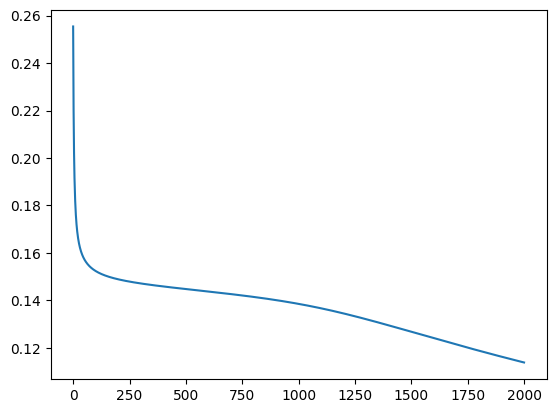

In [369]:
plt.plot(losses)
plt.show()

Отобразим исходные данные классов

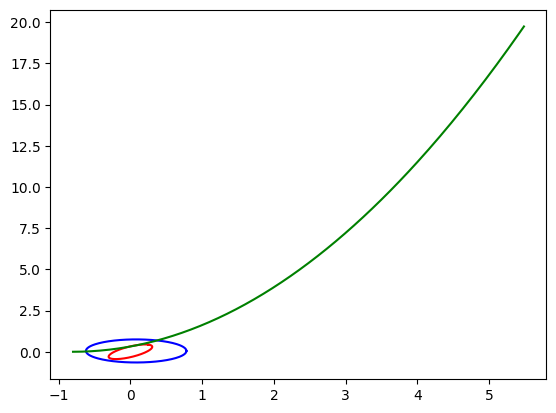

In [370]:
plt.plot(x1, y1, c = 'r')
plt.plot(x2, y2, c = 'b')
plt.plot(x3, y3, c = 'g')
plt.show()

Вычислим предсказания модели для каждой точки из области х =`[-18, 1]`  y=`[-1, 6]` и отобразим их

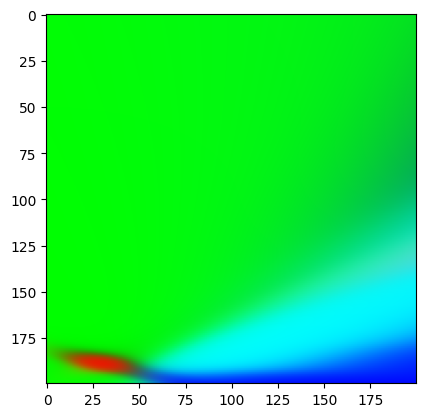

In [371]:
x = np.linspace(-18, 1, 200)
y = np.linspace(-1, 6, 200)

x_test = [[x, y] for x in np.linspace(-18, 1, 200) for y in np.linspace(-1, 6, 200)]
x_test = torch.FloatTensor(np.array(x_test))

prediction = predict(model1, x_test)
prediction = prediction.reshape((200, 200, 3))

plt.imshow(prediction)

### Задание 2

Теперь перейдем к задаче аппроксимации функции. Создадим разреженную дискретную версию нашей исходной функции и будем использовать ее для обучения, чтобы потом получить при увеличенни шага приближение исходной функции

In [401]:
def function(t):
   return np.sin(t**2 - 10*t + 3)

In [402]:
t1 = np.linspace(1,6, 200)
f1 = function(t1)

t2 = np.linspace(1,6, 2000)
f2 = function(t2)

x_train2 = torch.FloatTensor(t1).view(-1, 1)
y_train2 = torch.FloatTensor(f1).view(-1, 1)
train_dataset2 = TensorDataset(x_train2, y_train2)

x_test2 = torch.FloatTensor(t2).view(-1, 1)

Создадим класс трехслойной сети

In [403]:
class ThreeLayerModel(nn.Module):
    def __init__(self, in_features: int, hidden_layer: list, out_features: int):
        super().__init__()
        assert len(hidden_layer) == 2
        self.fc1 = nn.Linear(in_features, hidden_layer[0])
        self.fc2 = nn.Linear(hidden_layer[0], hidden_layer[1])
        self.fc3 = nn.Linear(hidden_layer[1], out_features)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

Нейросеть принимает на вход один признак - координату x, на выходе выдавает также один признак - значение функции в этой точке. 
Функция потерь - MSE.

In [409]:
model2 = ThreeLayerModel(1, [40, 12], 1)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.05)

Обучим модель, по аналогии с предыдущей используем батчи. 

In [410]:
train_loader2 = DataLoader(train_dataset2, 10)
losses2 = fit(model2, train_loader2, loss_func, optimizer, 2500)

Epoch 000 t_loss: 0.4489

Epoch 100 t_loss: 0.3683

Epoch 200 t_loss: 0.3669

Epoch 300 t_loss: 0.3661

Epoch 400 t_loss: 0.3653

Epoch 500 t_loss: 0.3643

Epoch 600 t_loss: 0.3627

Epoch 700 t_loss: 0.3600

Epoch 800 t_loss: 0.3551

Epoch 900 t_loss: 0.3486

Epoch 1000 t_loss: 0.3415

Epoch 1100 t_loss: 0.3317

Epoch 1200 t_loss: 0.3292

Epoch 1300 t_loss: 0.3251

Epoch 1400 t_loss: 0.3205

Epoch 1500 t_loss: 0.3152

Epoch 1600 t_loss: 0.3065

Epoch 1700 t_loss: 0.2962

Epoch 1800 t_loss: 0.2861

Epoch 1900 t_loss: 0.2749

Epoch 2000 t_loss: 0.2628

Epoch 2100 t_loss: 0.2532

Epoch 2200 t_loss: 0.2425

Epoch 2300 t_loss: 0.2327

Epoch 2400 t_loss: 0.2236



Отобразим график функции потерь

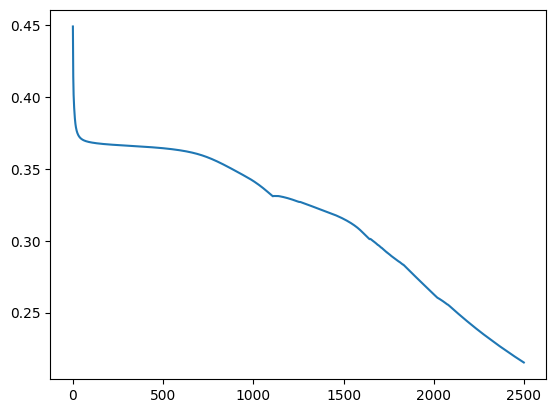

In [428]:
plt.plot(losses2)
plt.show()

Вычислим предсказанные моделью значения функции

In [413]:
f2_pred = predict(model2, x_test2)

Отобразим полученные результаты и сравним предсказанную аппроксимацию и истинные значения функции 

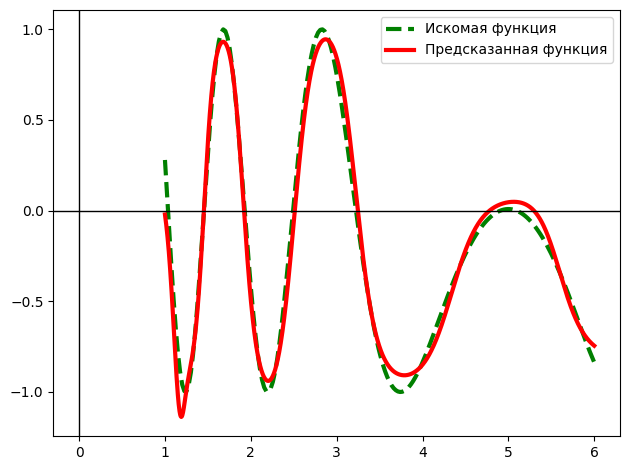

In [427]:
plt.plot(t1, f1, color="green", label='Искомая функция', linestyle='--', linewidth=3)
plt.plot(t2, f2_pred, color="red", label='Предсказанная функция', linewidth=3)

plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.axvline(x=0, color='k', linestyle='-', linewidth=1)

plt.legend()
plt.tight_layout()
plt.show()


**`Выводы:`** в ходе данной работы были построены две многослойные сети, которые были использованы для решения задач классификация линейно неразделимых данных и аппроксимации функции.

Обучение на 2500 эпохах позволило получить весьма точные результаты. Как видно из графика losses, ошибка падала очень стремительно на протяжении всего обучения, при этом изначально она была довольно большой - 0.4.